In [1]:
# Display matplotlib plots in the output
%matplotlib inline

# Support for running R code in the same notebook as Python (see below)
%load_ext rpy2.ipython

import json
import random
import re
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import *
from sklearn.naive_bayes import BernoulliNB
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier

from scipy.sparse import coo_matrix, vstack

In [22]:
REPO_ROOT = "/usr/src/app"

def tokenize_js(script):
    script = re.sub(r'(\/\*[^*]+\*\/)', "", script)
    script = re.sub(r'\/\/.+', "", script)
    tokens = re.findall(r'(\"[^"]+\"|\'[^\']+\'|[\w\\\/\-_\"\']+|{|}|,|[\+\*]|\(|\)|\.|/\*.+\*\/)', script)
    return [t.lower() for t in tokens]

def parse_scripts(tbl):
    for item in tbl:
        with open("%s/scripts/%s.js" % (REPO_ROOT, item["sha"])) as f:
            yield f.read().decode(errors='replace')

def _tokenize_helper(node):
    if isinstance(node, basestring):
        return [node]
    if isinstance(node, bool):
        return ["True" if node else "False"]
    if isinstance(node, list):
        return [x for v in node for x in _tokenize_helper(v)]
    if node is None:
        return []
    
    lst = [".".join([
        "%s:%s" % (key, val)
        for key, val in node.iteritems()
        if not isinstance(val, dict) and not isinstance(val, list)
    ])]
    
    for key, val in node.iteritems():
        if isinstance(val, dict) or isinstance(val, list):
            lst += _tokenize_helper(val)
    
    return lst

def tokenize_js_ast(ast):
    try:
        ast_json = json.loads(ast)
    except Exception as e:
        print "Failed to parse JSON! %s" % str(e)
        return []
    return [t.lower() for t in _tokenize_helper(ast_json)]
    
def parse_scripts_ast(tbl):
    for item in tbl:
        try:
            with open("%s/scripts-ast/%s.js.ast" % (REPO_ROOT, item["sha"])) as f:
                yield f.read()
        except IOError:
            yield "[]"

def train_all(tokenizer, parser):
    X_train = {}
    Y_train = {}
    X_test = {}
    Y_test = {}

    for train_size in TRAIN_SIZES:
        print "Training size %d" % train_size
        vectorizer = TfidfVectorizer(tokenizer=tokenizer)
        X_train[train_size] = vectorizer.fit_transform(parser(train_tables[train_size]))
        Y_train[train_size] = np.array([item["flag-any"] for item in train_tables[train_size]])
        X_test[train_size] = vectorizer.transform(parser(test_table))
        Y_test[train_size] = np.array([item["flag-any"] for item in test_table])
        
    return X_train, Y_train, X_test, Y_test

def test_model(model, model_type, model_name):
    for train_size in TRAIN_SIZES:
        model.fit(X_train[train_size], Y_train[train_size])
        test_pred = model.predict(X_test[train_size])
        test_y = Y_test[train_size]
        
        accuracy = (float(sum(test_y == test_pred))) / len(test_pred)
        precision = (float(sum((test_y == test_pred) & (test_pred == 1)))) / float(max(1, sum(test_pred == 1)))
        recall = (float(sum((test_y == test_pred) & (test_pred == 1)))) / float(sum(test_y == 1))
        f1 = 2 * (precision * recall) / max(1, precision + recall)

        print "%s %s. Train set size %d. %f%% / %f%% / %f%% (%f)" % (
            model_type,
            model_name,
            train_size,
            accuracy * 100,
            precision * 100,
            recall * 100,
            f1)
        
        output_table.append([
            model_type,
            model_name,
            train_size, 
            accuracy,
            precision,
            recall,
            f1,
        ])
        
def write_results():
    output = ("Model,Training set,Accuracy,Precision,Recall,F1 score\n" +
        "\n".join([",".join([str(s) for s in row]) for row in output_table]))
    with open("%s/results/linear_models.csv" % REPO_ROOT, "w") as f:
        f.write(output)
        
def write_min_dataset():
    min_table = (
            [table[i] for i in positive_examples] + 
            [table[i] for i in negative_examples])
    with open("%s/scripts/min/table_flag.json" % REPO_ROOT, "w") as f:
        json.dump(min_table, f)
    
    for item in min_table:
        with open("%s/scripts/%s.js" % (REPO_ROOT, item["sha"])) as f1:
            with open("%s/scripts/min/%s.js" % (REPO_ROOT, item["sha"]), "w") as f2:
                f2.write(f1.read())
    print "Wrote %d items" % len(min_table)        

In [3]:
with open("%s/scripts/table_flag.json" % REPO_ROOT) as f:
    raw_table = json.load(f)

# Filter out inline scripts for now
raw_table = [i for i in raw_table if i["inline"] == False]

scripts_table = {}
for item in raw_table:
    if item["sha"] not in scripts_table:
        scripts_table[item["sha"]] = item
        scripts_table[item["sha"]]["count"] = 0
        
    for entry in item:
        if entry.startswith("flag-"):
            if item[entry] == 1:
                scripts_table[item["sha"]][entry] = 1
                
    scripts_table[item["sha"]]["count"] += 1
    
table = scripts_table.values()

positive_examples = [i for i, e in enumerate(table) if e["flag-any"] == 1]
negative_examples = [i for i, e in enumerate(table) if e["flag-any"] == 0]
random.seed(1492)
random.shuffle(positive_examples)
random.shuffle(negative_examples)
negative_examples = negative_examples[:len(positive_examples)]
TOTAL_SIZE = len(positive_examples)+len(negative_examples)
print "%d items in raw table." % len(raw_table)
print "%d unique scripts." % len(table)
print "%d positive + %d negative examples = %d total." % (
    len(positive_examples), len(negative_examples),
    TOTAL_SIZE)

TRAIN_SIZES = []
size = 375
while size < TOTAL_SIZE - 1000:
    TRAIN_SIZES.append(size)
    size *= 2
    
TEST_SIZE = TOTAL_SIZE - TRAIN_SIZES[-1]

print "Training sizes: %s" % TRAIN_SIZES
print "Test size: %d" % TEST_SIZE

train_tables = {}
for train_size in TRAIN_SIZES:
    train_tables[train_size] = (
        [table[i] for i in positive_examples[:(train_size/2)]] + 
        [table[i] for i in negative_examples[:(train_size/2)]])

test_table = (
    [table[i] for i in positive_examples[-TEST_SIZE/2:]] + 
    [table[i] for i in negative_examples[-TEST_SIZE/2:]])

103314 items in raw table.
53547 unique scripts.
3582 positive + 3582 negative examples = 7164 total.
Training sizes: [375, 750, 1500, 3000, 6000]
Test size: 1164


In [4]:
output_table = []

In [5]:
X_train, Y_train, X_test, Y_test = train_all(tokenize_js, parse_scripts)

Training size 375
Training size 750
Training size 1500
Training size 3000
Training size 6000


In [6]:
test_model(KNeighborsClassifier(2), "RegEx", "KNN")

RegEx KNN. Train set size 375. 77.663230% / 84.401709% / 67.869416% (0.752381)
RegEx KNN. Train set size 750. 78.865979% / 83.600000% / 71.821306% (0.772643)
RegEx KNN. Train set size 1500. 81.271478% / 87.295082% / 73.195876% (0.796262)
RegEx KNN. Train set size 3000. 83.333333% / 88.339921% / 76.804124% (0.821691)
RegEx KNN. Train set size 6000. 84.536082% / 89.105058% / 78.694158% (0.835766)


In [7]:
test_model(BernoulliNB(), "RegEx", "Bernoulli")

RegEx Bernoulli. Train set size 375. 58.247423% / 54.651163% / 96.907216% (0.698885)
RegEx Bernoulli. Train set size 750. 60.309278% / 55.952381% / 96.907216% (0.709434)
RegEx Bernoulli. Train set size 1500. 61.683849% / 56.868687% / 96.735395% (0.716285)
RegEx Bernoulli. Train set size 3000. 64.347079% / 58.670820% / 97.079038% (0.731392)
RegEx Bernoulli. Train set size 6000. 65.635739% / 59.498956% / 97.938144% (0.740260)


In [8]:
test_model(linear_model.SGDClassifier(n_iter=1000, loss="log"), "RegEx", "SGD")

RegEx SGD. Train set size 375. 79.295533% / 82.725528% / 74.054983% (0.781505)
RegEx SGD. Train set size 750. 81.615120% / 82.974910% / 79.553265% (0.812281)
RegEx SGD. Train set size 1500. 81.872852% / 85.199241% / 77.147766% (0.809739)
RegEx SGD. Train set size 3000. 84.450172% / 86.788991% / 81.271478% (0.839397)
RegEx SGD. Train set size 6000. 85.223368% / 87.822878% / 81.786942% (0.846975)


In [9]:
test_model(RandomForestClassifier(max_depth=15, n_estimators=100, max_features=30), "RegEx", "RandomForest")

RegEx RandomForest. Train set size 375. 72.250859% / 66.167291% / 91.065292% (0.766450)
RegEx RandomForest. Train set size 750. 74.484536% / 68.015171% / 92.439863% (0.783685)
RegEx RandomForest. Train set size 1500. 73.109966% / 66.875784% / 91.580756% (0.773024)
RegEx RandomForest. Train set size 3000. 72.250859% / 65.696970% / 93.127148% (0.770434)
RegEx RandomForest. Train set size 6000. 70.532646% / 64.380265% / 91.924399% (0.757254)


In [10]:
test_model(VotingClassifier(estimators=[
            ('knn', KNeighborsClassifier(2)),
            ('rbf', SVC(kernel="rbf", probability=True)),
            ('sgd', linear_model.SGDClassifier(n_iter=1000, loss="log")),
            ('rf', RandomForestClassifier(max_depth=15, n_estimators=100, max_features=30))],
        voting='hard'),
    "RegEx", "VotingClassifier")

RegEx VotingClassifier. Train set size 375. 77.749141% / 85.185185% / 67.182131% (0.751201)
RegEx VotingClassifier. Train set size 750. 80.498282% / 86.298569% / 72.508591% (0.788049)
RegEx VotingClassifier. Train set size 1500. 81.615120% / 89.316239% / 71.821306% (0.796190)
RegEx VotingClassifier. Train set size 3000. 82.817869% / 88.663968% / 75.257732% (0.814126)
RegEx VotingClassifier. Train set size 6000. 84.020619% / 88.976378% / 77.663230% (0.829358)


In [11]:
test_model(LinearSVC(), "RegEx", "LinearSVC")

RegEx LinearSVC. Train set size 375. 78.436426% / 83.434343% / 70.962199% (0.766945)
RegEx LinearSVC. Train set size 750. 80.841924% / 82.935780% / 77.663230% (0.802130)
RegEx LinearSVC. Train set size 1500. 82.560137% / 86.372361% / 77.319588% (0.815956)
RegEx LinearSVC. Train set size 3000. 86.340206% / 88.950276% / 82.989691% (0.858667)
RegEx LinearSVC. Train set size 6000. 87.886598% / 88.752197% / 86.769759% (0.877498)


In [12]:
test_model(MLPClassifier(alpha=1e-4, learning_rate="adaptive",
             hidden_layer_sizes=(12,), random_state=1),
    "RegEx", "Neural Network")

/usr/local/lib/python2.7/dist-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


RegEx Neural Network. Train set size 375. 82.044674% / 83.363148% / 80.068729% (0.816827)
RegEx Neural Network. Train set size 750. 84.364261% / 85.714286% / 82.474227% (0.840630)
RegEx Neural Network. Train set size 1500. 84.965636% / 85.890653% / 83.676976% (0.847694)
RegEx Neural Network. Train set size 3000. 87.457045% / 87.847222% / 86.941581% (0.873921)
RegEx Neural Network. Train set size 6000. 88.230241% / 87.904600% / 88.659794% (0.882806)


In [13]:
X_train, Y_train, X_test, Y_test = train_all(tokenize_js_ast, parse_scripts_ast)

Training size 375
Training size 750
Training size 1500
Training size 3000
Failed to parse JSON! maximum recursion depth exceeded while calling a Python object
Training size 6000
Failed to parse JSON! maximum recursion depth exceeded while calling a Python object


In [14]:
test_model(KNeighborsClassifier(2), "AST", "KNN")

AST KNN. Train set size 375. 76.975945% / 88.292683% / 62.199313% (0.729839)
AST KNN. Train set size 750. 77.147766% / 86.915888% / 63.917526% (0.736634)
AST KNN. Train set size 1500. 80.498282% / 84.735812% / 74.398625% (0.792315)
AST KNN. Train set size 3000. 81.786942% / 85.440613% / 76.632302% (0.807971)
AST KNN. Train set size 6000. 84.879725% / 86.379928% / 82.817869% (0.845614)


In [15]:
test_model(BernoulliNB(), "AST", "Bernoulli")

AST Bernoulli. Train set size 375. 58.676976% / 54.926829% / 96.735395% (0.700685)
AST Bernoulli. Train set size 750. 60.910653% / 56.343656% / 96.907216% (0.712571)
AST Bernoulli. Train set size 1500. 61.254296% / 56.556557% / 97.079038% (0.714738)
AST Bernoulli. Train set size 3000. 64.003436% / 58.393409% / 97.422680% (0.730200)
AST Bernoulli. Train set size 6000. 64.604811% / 58.780992% / 97.766323% (0.734194)


In [16]:
test_model(linear_model.SGDClassifier(n_iter=1000), "AST", "SGD")

AST SGD. Train set size 375. 81.786942% / 83.273381% / 79.553265% (0.813708)
AST SGD. Train set size 750. 83.161512% / 83.623693% / 82.474227% (0.830450)
AST SGD. Train set size 1500. 84.879725% / 87.453875% / 81.443299% (0.843416)
AST SGD. Train set size 3000. 86.855670% / 87.565674% / 85.910653% (0.867303)
AST SGD. Train set size 6000. 87.800687% / 88.732394% / 86.597938% (0.876522)


In [17]:
test_model(RandomForestClassifier(max_depth=15, n_estimators=100, max_features=30), "AST", "RandomForest")

AST RandomForest. Train set size 375. 73.883162% / 69.359331% / 85.567010% (0.766154)
AST RandomForest. Train set size 750. 74.398625% / 68.346253% / 90.893471% (0.780236)
AST RandomForest. Train set size 1500. 73.195876% / 67.131980% / 90.893471% (0.772263)
AST RandomForest. Train set size 3000. 73.024055% / 66.262136% / 93.814433% (0.776671)
AST RandomForest. Train set size 6000. 73.797251% / 67.035670% / 93.642612% (0.781362)


In [18]:
test_model(VotingClassifier(estimators=[
            ('knn', KNeighborsClassifier(2)),
            ('rbf', SVC(kernel="rbf", probability=True)),
            ('sgd', linear_model.SGDClassifier(n_iter=1000, loss="log")),
            ('rf', RandomForestClassifier(max_depth=15, n_estimators=100, max_features=30))],
        voting='hard'),
    "AST", "VotingClassifier")

AST VotingClassifier. Train set size 375. 79.982818% / 89.213483% / 68.213058% (0.773126)
AST VotingClassifier. Train set size 750. 79.982818% / 89.213483% / 68.213058% (0.773126)
AST VotingClassifier. Train set size 1500. 81.357388% / 89.247312% / 71.305842% (0.792741)
AST VotingClassifier. Train set size 3000. 82.388316% / 89.517820% / 73.367698% (0.806421)
AST VotingClassifier. Train set size 6000. 85.567010% / 89.204545% / 80.927835% (0.848649)


In [19]:
test_model(LinearSVC(), "AST", "LinearSVC")

AST LinearSVC. Train set size 375. 80.841924% / 82.935780% / 77.663230% (0.802130)
AST LinearSVC. Train set size 750. 81.958763% / 83.453237% / 79.725086% (0.815466)
AST LinearSVC. Train set size 1500. 84.020619% / 85.740072% / 81.615120% (0.836268)
AST LinearSVC. Train set size 3000. 87.371134% / 87.958115% / 86.597938% (0.872727)
AST LinearSVC. Train set size 6000. 88.745704% / 89.354276% / 87.972509% (0.886580)


In [20]:
test_model(MLPClassifier(alpha=1e-4, learning_rate="adaptive",
             hidden_layer_sizes=(12,), random_state=1),
    "AST", "Neural Network")

AST Neural Network. Train set size 375. 83.676976% / 87.121212% / 79.037801% (0.828829)
AST Neural Network. Train set size 750. 84.707904% / 86.071429% / 82.817869% (0.844133)
AST Neural Network. Train set size 1500. 86.168385% / 85.982906% / 86.426117% (0.862039)
AST Neural Network. Train set size 3000. 87.285223% / 86.904762% / 87.800687% (0.873504)
AST Neural Network. Train set size 6000. 89.261168% / 89.739130% / 88.659794% (0.891962)


In [23]:
write_results()

In [24]:
table_df = pd.DataFrame(output_table)
%Rpush table_df

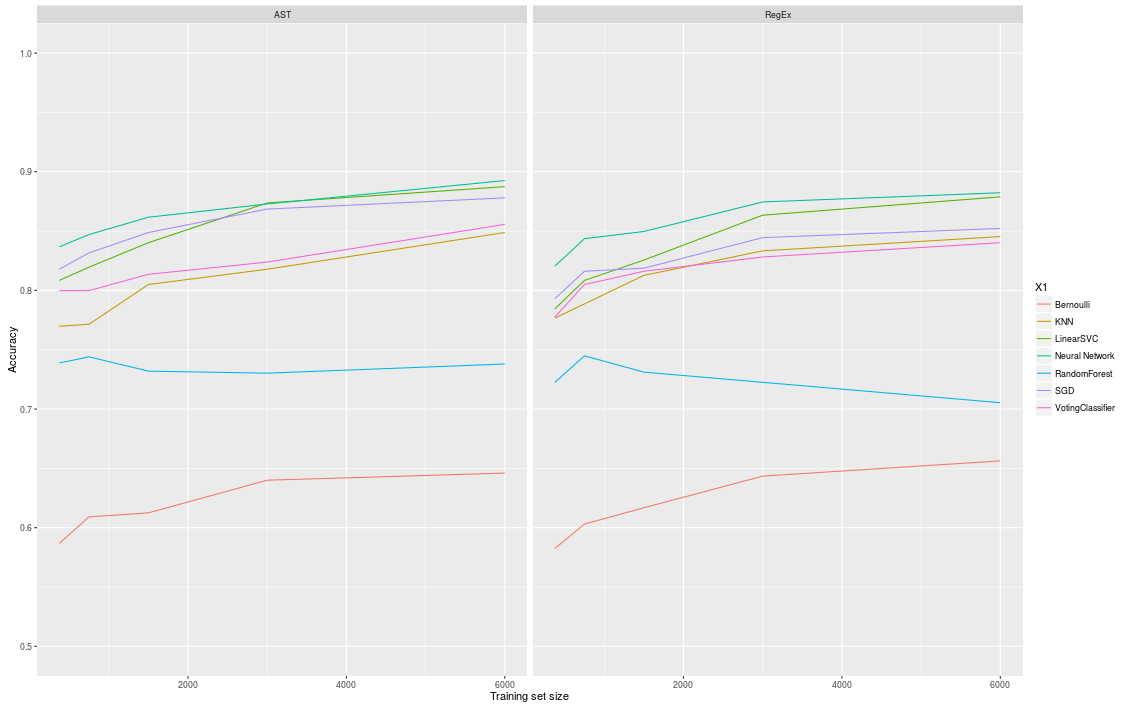

In [38]:
%%R -w 40 -h 25 -u cm

library(ggplot2)
ggplot(aes(x=X2, color=X1, y=X3), data=table_df) +
    geom_line() +
    xlab("Training set size") +
    ylim(c(0.5, 1)) +
    ylab("Accuracy") +
    facet_grid(~ X0)